In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
mnist = datasets.MNIST(root='./data', download=True, transform=None)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
len(mnist)

60000

In [4]:
mnist[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FCA11A55790>, 5)

# Plotting the images for mnist datasets

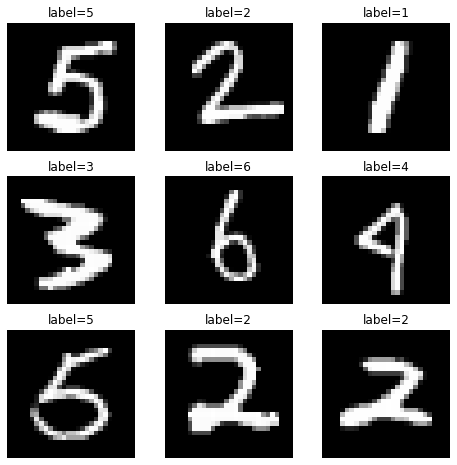

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist), size=(1,)).item()
    img, label = mnist[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'label={label}')
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

## Generating second dataset of random numbers from 0 to 9
Curently considering length of dataset same as that of length of mnist dataset

In [6]:
num = np.random.randint(low=0, high=10, size=len(mnist))
X1 = np.zeros((num.size, num.max()+1))
X1 [np.arange(num.size),num] = 1
print(f"Printing the output labels: {num}")
print(f"Printing the onehot encoded numbers Input: {X1}")

Printing the output labels: [1 2 0 ... 3 3 6]
Printing the onehot encoded numbers Input: [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Generating the Dataset 

In [7]:
class Dataset_prep(Dataset):
    
    # reading the image from mnist and taking random int.
    def __init__(self, X1, num, mnist):
        self.X1 = X1
        self.mnist = mnist
        self.num = num
    
    # number of rows in dataset [Considering length of mnist right now]
    def __len__(self):
        return len(self.num)
    
    # get image, its label, num, and added number.
    def __getitem__(self, index):
        image = ToTensor()(self.mnist[index][0]) # Transforming to tensor
        number = torch.from_numpy(self.X1[index])
        label1 = torch.tensor([self.mnist[index][1]])
        label2 = self.num[index]
        # Added number label
        label2 = label2 + self.mnist[index][1]
        label2 = torch.tensor([label2])

        return {'image':image,'number':number,'label1':label1,'label2':label2}

In [8]:
dataset = Dataset_prep(X1, num, mnist)

In [9]:
len(dataset)

60000

In [10]:
batch = iter(dataset)

In [11]:
datadict = next(batch)
print(datadict['label1'])
print(datadict['label2'])
print(datadict['number'].shape)
print(datadict['image'].shape)
datadict2 = next(batch)
print(datadict2['label1'])
print(datadict2['label2'])
print(datadict2['number'].shape)
print(datadict2['image'].shape)

tensor([5])
tensor([6])
torch.Size([10])
torch.Size([1, 28, 28])
tensor([0])
tensor([2])
torch.Size([10])
torch.Size([1, 28, 28])


In [12]:
# Train and Validation set
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])

In [13]:
# Data Loader
train_dataloader = DataLoader(train_set.dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(val_set.dataset, batch_size=64, shuffle=True)

In [14]:
dir(train_dataloader)
train_dataloader.dataset[0]

{'image': tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000,

## Creating the nnet model class

In [15]:
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input for Image: CNN based
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.FC11 = nn.Linear(32*7*7, 64)
          
        #Input for Model
        self.layer_1 = nn.Linear(10, 32)
        self.layer_2 = nn.Linear(32, 64)
        self.layer_3 = nn.Linear(64, 128)
        self.layer_4 = nn.Linear(128, 64)
        
        self.out2 = nn.Linear(128, 19) # it will have addition from 0 to 18 so 19
        self.out1 = nn.Linear(128, 10) # It will have 10 classes from 0-9 and concatinated layer of 128

    def forward(self, x1, x2):
        x1 = x1.reshape(-1, 1, 28, 28)
        x1 = F.max_pool2d(F.relu(self.conv1(x1)),(2,2))
        x1 = F.max_pool2d(F.relu(self.conv2(x1)),(2,2))
        # print(f'x1.shape_after_conv:{x1.shape}')
        x1 = x1.reshape(-1, 32*7*7)
        # print(f'new: {x1.shape}')
        x1 = self.FC11(x1)
        # print(f'newfc: {x1.shape}')
        # x2 = x2.view(-1, x2.size(0)).float()
        x2 = x2.reshape(1, 10)
        # print(f'x2: {x2.shape}')
        x2 = F.relu(self.layer_1(x2.float()))
        # print(f'x2.shape{x2.shape}')
        x2 = F.relu(self.layer_2(x2))
        # print(f'x2.shape{x2.shape}')
        x2 = F.relu(self.layer_3(x2))
        x2 = F.relu(self.layer_4(x2))
        # Concatinating the fc layers of mnist and number
        x = torch.cat((x1, x2), dim=1)
        # print(f'x: {x.shape}')
        out1 = self.out1(x)
        out2 = self.out2(x)
      
        return {'label1':out1, 'label2':out2}



In [16]:
model = Model()
opt = optim.SGD(model.parameters(), lr=10E-3)

print(model)

Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (FC11): Linear(in_features=1568, out_features=64, bias=True)
  (layer_1): Linear(in_features=10, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (out2): Linear(in_features=128, out_features=19, bias=True)
  (out1): Linear(in_features=128, out_features=10, bias=True)
)


In [17]:
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()

In [18]:
# Making sure that training is performed on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
num_epochs = 4

def train_model(num_epochs, model, criterion1, criterion2, optimizer):
    valid_loss_min = np.Inf
    for epoch in range(1, num_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        # train the model #
        model.train()
        for batch_idx, batch in enumerate(train_dataloader.dataset):

            # importing data and moving to GPU
            image = batch['image'].to(device)
            # print(image)
            number = batch['number'].to(device)
            # print(number)
            # print(number.shape)
            label1 = batch['label1'].to(device)
            label2 = batch['label2'].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            output=model(image, number)
            label1_hat=output['label1']
            label2_hat=output['label2']
            # print(f' y: {label1}')

            # print(f'y_hat:{label1_hat}') 
            #print(label1.shape) 
            #print(label1_hat.shape)

                 
            # calculate loss
            loss1=criterion1(label1_hat, label1)
            # print(f'label 2: {label2}')
            # print(f'label2_hat: {label2_hat}')
            # print(f'loss: {nn.CrossEntropyLoss(label2_hat, label2)}')
            loss2=criterion2(label2_hat, label2)
                
            loss=loss1+loss2
            
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 50 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        # validate the model #
        model.eval()
        for batch_idx, batch in enumerate(test_dataloader.dataset):
            image = batch['image'].to(device)
            # print(image)
            number = batch['number'].to(device)
            label1 = batch['label1'].to(device)
            label2 = batch['label2'].to(device)
            # print(label1)
            
            output= model(image, number)
            label1_hat=output['label1']
            label2_hat=output['label2']
            # print(label1_hat) 
            # print(label1_hat.shape)
          
            # calculate loss
            loss1=criterion1(label1_hat, label1)
            loss2=criterion2(label2_hat, label2)
 
            loss=loss1+loss2
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
            # print training/validation statistics 
            print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
        
    # return trained model
    return model

In [20]:
model_out = train_model(num_epochs, model, criterion1, criterion2, opt)

Epoch 1, Batch 1 loss: 5.159516


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Streaming output truncated to the last 5000 lines.
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266365
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266363
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266351
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266360
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266359
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266377
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266360
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266340
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266344
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266322
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266394
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266380
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266385
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266365
Epoch: 3 	Training Loss: 1.281497 	Validation Loss: 1.266355
Epoch: 3 	Training Loss: 1.281497 

In [21]:

prediction = model(train_dataloader.dataset[0]['image'], train_dataloader.dataset[0]['number'])

In [22]:
prediction

{'label1': tensor([[-4.1065, -3.1094, -4.0920,  2.1197, -1.9170,  9.1153,  2.3200, -0.6874,
           0.6051,  1.4400]], grad_fn=<AddmmBackward>),
 'label2': tensor([[ -2.2587,   8.4145,  13.2392,  18.0544,  19.8932,  21.4266,  23.9472,
           22.4666,  24.1001,  20.7890,  17.1193,   6.7382,  -4.5856, -10.9834,
          -17.0472, -27.6351, -36.2526, -45.4224, -52.0836]],
        grad_fn=<AddmmBackward>)}

In [23]:
np.argmax(prediction['label1'].detach().numpy())

5

In [24]:
np.argmax(prediction['label2'].detach().numpy())

8

In [25]:
prediction = model(test_dataloader.dataset[0]['image'], train_dataloader.dataset[0]['number'])

In [26]:
print(np.argmax(prediction['label1'].detach().numpy()), test_dataloader.dataset[0]['label1'].detach().numpy()[0])
print(np.argmax(prediction['label2'].detach().numpy()), test_dataloader.dataset[0]['label2'].detach().numpy()[0])

5 5
8 6


In [27]:
mnist_label1 = []
add_label2 = []

for batch in dataset:
  image = batch['image'].to(device)
  number = batch['number'].to(device)
  label1 = batch['label1'].to(device)
  label2 = batch['label2'].to(device)


  prediction = model(image, number)
  #print(f"predicted label = {np.argmax(prediction['label1'].detach().numpy())}")
  #print(f"target label = {label1.detach().numpy()[0]}")
  if np.argmax(prediction['label1'].detach().numpy()) == label1.detach().numpy()[0]:
    mnist_label1.append(True)
  if np.argmax(prediction['label2'].detach().numpy()) == label2.detach().numpy()[0]:
      add_label2.append(True)

In [28]:
print(f'Accuracy of Mnist dataset on training: {(len(mnist_label1)/len(mnist))*100}')

Accuracy of Mnist dataset on training: 98.16333333333334


In [29]:
print(f'Accuracy of Mnist dataset on training: {(len(add_label2)/len(mnist))*100}')

Accuracy of Mnist dataset on training: 51.575
